<div align="center">



</div>

<!-- <br> le permite hacer espacios -->
<br>

<hr size=10 noshade color="green">
<p>
<p><img alt="UdeA logo" height="180px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="100px" vspace="4px"></p>

<div align="right">       

<h3><i> <b>Manuela Marín Gómez<br>

</b> <br>
Universidad de Antioquia <br>
Instituto de Física  <br>
</i></h3>




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# **Parte 1**

## *Propagación de rayos de luz en un espacio-tiempo curvo mediante la aproximación Eikonal*

Inicialmente se generaron $N =500$ puntos $(y_0,z_0)$ distribuidos uniformemente dentro de un círculo de radio $R=70$ (unidades naturales) en el plano $yz$

In [ ]:
N = 500 #Número de rayos
R = 70  #Radio del cículo en el plano yz

Para garantizar una distribución espacialmente uniforme de los rayos dentro de un círculo, se utilizó un método de muestreo en coordenadas polares que considera la densidad de área. La probabilidad de que un punto caiga dentro de un anillo de radio $r$ y grosor diferencial $dr$ es proporcional al área de dicho anillo. De este modo, para tener una distribución uniforme sobre el área del círculo, es necesario que los puntos se distribuyan uniformemente con respecto a esta área diferencial:

$$
r = R \sqrt{u}
$$

donde $u$ es una variable aleatoria con distribución uniforme en el intervalo $[0, 1]$.


Asimismo, los ángulos $\theta$ se generaron de manera uniforme en el intervalo $[0, 2\pi]$.

Las coordenadas cartesianas correspondientes se obtuvieron mediante la transformación:


\begin{equation}
  y_0 = r \cos(θ), \ z_0 = r \sin(θ)
\end{equation}

In [ ]:
def generar_circulo(N, R):
  # Generamos puntos uniformemente distribudios
  r = R * np.sqrt(np.random.rand(N))
  theta = 2 * np.pi * np.random.rand(N)

  # Convertimos las coordenadas polares a coordenadas cartesianas en el plano yz
  y0 = r * np.cos(theta)
  z0 = r * np.sin(theta)
  return r, theta, y0, z0

In [ ]:
# Posiciones iniciales
r0, theta0, y0, z0 = generar_circulo(N, R)

### Visualización de la distribución de la posición inicial de los rayos en el plano $yz$

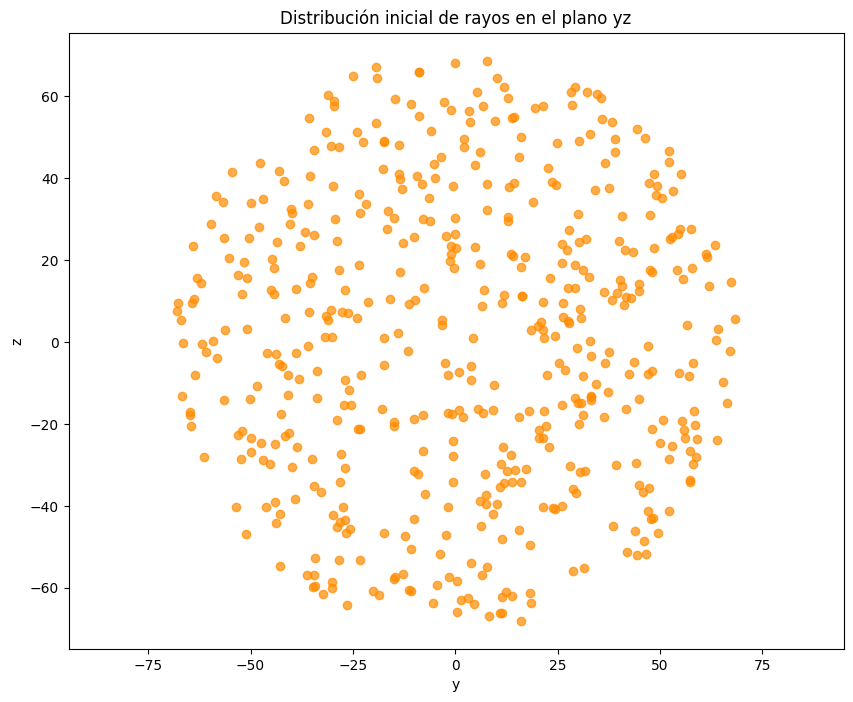

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y0, z0, 'o', alpha=0.7, color = 'darkorange')
plt.xlabel('y')
plt.ylabel('z')
plt.title('Distribución inicial de rayos en el plano yz')
plt.axis('equal')
plt.show()

# **Parte 2**

## *Integración de rayos en el tiempo en el plano $xy$*

In [ ]:
def refindex(x, y, A):
  eps = 1e-6
  rp0 = np.sqrt(x**2 + y**2)
  n = 1 / (1 - A / (rp0 + eps))
  fac = np.abs((1 - 9 * (A / rp0)**2 / 8))
  nx = -fac * n**2 * A * x / (rp0 + eps)**3
  ny = -fac * n**2 * A * y / (rp0 + eps)**3
  return [n, nx, ny]

def flow_deriv(x_y_z, t, A):
  x, y, z, w = x_y_z
  n, nx, ny = refindex(x, y, A)
  dxdt = z / n
  dydt = w / n
  dzdt = nx
  dwdt = ny
  return [dxdt, dydt, dzdt, dwdt]

Se simula la propagación de rayos de luz en un espacio-tiempo curvo  alrededor de un  agujero negro con un radio gravitacional $A=10$. Los rayos se inicializan en el plano
$xy$ y se integran numéricamente en el tiempo.

Para cada rayo, se definió un vector de estado en el plano $xy$ que contiene su posición y dirección de propagación. Se tomó como posición inicial:

$$
x_{\text{start}} = -100, \quad y_{\text{start}} = r_0
$$

donde $r_0$ es la distancia radial de cada uno de los N puntos generados en el círculo de radio R.

Se integró la trayectoria de cada rayo en el intervalo de tiempo:

$$
t \in [0, 400], \quad \Delta t = 1
$$

In [ ]:
# Parámetros
A = 10 #Radio gravitacional del agujero negro
x_start = -100
xmax, ymax = 300, 300
tmax, dt = 400, 1

subconjunto_trayectorias = np.arange(0, N, 10)

Los rayos se inicializan en el plano $xy$ y se integran numéricamente en el tiempo, verificando dos condiciones de terminación:



1.   Se evalua si el rayo colisiona con el agujero negro. Para ello, se verifica si en algún instante de tiempo se cumple que:

  $$
  \sqrt{x^2 + y^2} < A, \quad \text{con } A = 10
  $$
  Si esta condición se cumple, se considera que el rayo ha sido absorbido por el agujero negro y se trunca la trayectoria en ese punto.

2. Con el fin de evitar que los rayos se propaguen indefinidamente, se estableció  un límite espacial máximo. Si en algún momento se cumple que:

  $$
  x > 300 \quad \text{o} \quad y >  300
  $$
  se detiene también la integración, descartando los puntos posteriores.



In [ ]:
def integracion_rayo(x_start, r0):
  trayectorias_rayo = []
  xmax = 300
  ymax = 300
  tspan = np.arange(0, 401, 1)

  for y_start in r0:
    #Inicializamos el vector de estado en 2D
    estado_inicial = [x_start, y_start, 1, 0] #El rayo se mueve con velocidad unitaria en x
    sol = odeint(flow_deriv, estado_inicial, tspan, args=(A,)) #Resolvemos las ecuaciones diferenciales

    #Calculamos la distancia al origen en cada punto de la trayectoria
    radios = np.sqrt(sol[:, 0]**2 + sol[:, 1]**2)
    colisionan = np.where(radios < A)[0] #Verificamos si el rayo cae en el agujero

    #Verificamos si el rayo se sale de los límites establcidos
    fuera_x = abs(sol[:, 0]) > xmax
    fuera_y = abs(sol[:, 1]) > ymax
    escapan = np.where(fuera_x | fuera_y)[0]

    #Si los rayos son absorbidos por el agujero, se trunca la trayectoria
    if len(colisionan) > 0:
      sol = sol[:colisionan[0]]
    #Si los rayos se escapan, se trunca la trayectoria
    elif escapan.size > 0:
      sol = sol[:escapan[0]]
    trayectorias_rayo.append(sol)
  return trayectorias_rayo

In [ ]:
trayectorias = integracion_rayo(x_start, r0)

<ipython-input-61-1a8249dbd0e9>:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(flow_deriv, estado_inicial, tspan, args=(A,)) #Resolvemos las ecuaciones diferenciales
<ipython-input-61-1a8249dbd0e9>:13: RuntimeWarning: overflow encountered in square
  radios = np.sqrt(sol[:, 0]**2 + sol[:, 1]**2)
<ipython-input-61-1a8249dbd0e9>:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(flow_deriv, estado_inicial, tspan, args=(A,)) #Resolvemos las ecuaciones diferenciales
<ipython-input-61-1a8249dbd0e9>:13: RuntimeWarning: overflow encountered in square
  radios = np.sqrt(sol[:, 0]**2 + sol[:, 1]**2)


### Visualización del subconjunto de trayectorias

Para verificar que la deflexión fue simulada correctamente, veamos si los rayos cambian de dirección al aproximarse al agujero negro.

<ipython-input-61-1a8249dbd0e9>:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(flow_deriv, estado_inicial, tspan, args=(A,)) #Resolvemos las ecuaciones diferenciales
<ipython-input-61-1a8249dbd0e9>:13: RuntimeWarning: overflow encountered in square
  radios = np.sqrt(sol[:, 0]**2 + sol[:, 1]**2)


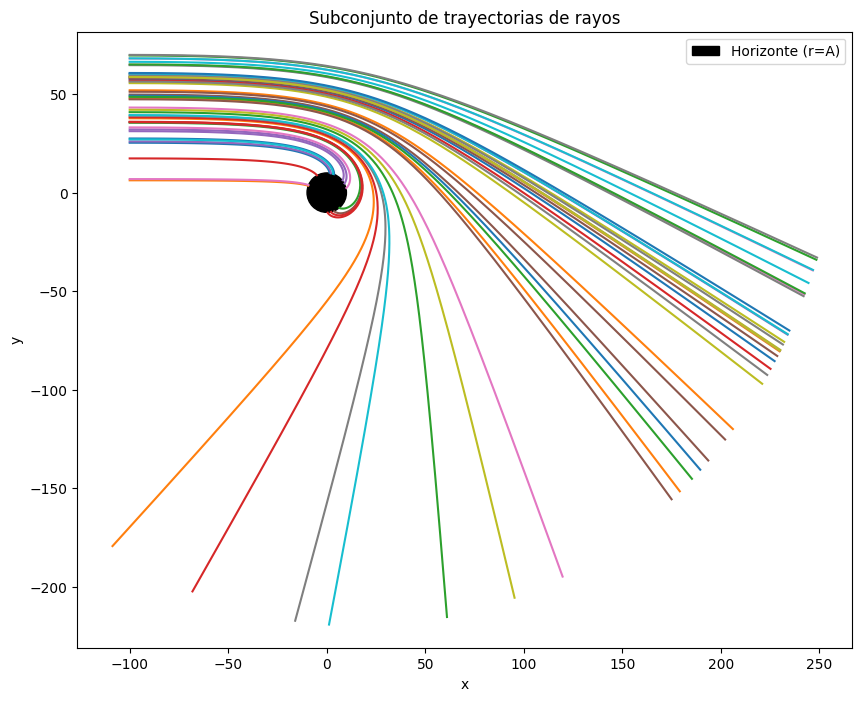

In [ ]:
plt.figure(figsize=(10, 8))
#Realizamos la integración de los rayos solo para un subconjunto de posiciones iniciales
sub =  integracion_rayo(x_start, r0[subconjunto_trayectorias])
for i in sub:
    x, y = i[:, 0], i[:, 1]
    plt.plot(x, y)
circle = plt.Circle((0, 0), A, color='black', fill=True, label='Horizonte (r=A)') #Horizonte de eventos del agujero negro
plt.gca().add_patch(circle)

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Subconjunto de trayectorias de rayos')
plt.axis('equal')
plt.legend()
plt.show()

# **Parte 3**


## *Construcción de un disco inclinado*

Para simular la presencia de un disco de acreción delgado alrededor de un agujero negro, se generó un conjunto de puntos distribuidos uniformemente dentro de un anillo. Posteriormente, este anillo es rotado para representar un disco inclinado con respecto al plano del observador.

Se generaronn $N_d \approx 5000$ puntos distribuidos uniformemente dentro de un anillo circular en el plano $yz$, con radio interno $R_{\text{in}} = 15$ y radio externo $R_{\text{out}} = 50$.


In [ ]:
#Parámetros del anillo
Nd = 5000
Rin = 15
Rout = 50

In [ ]:
def generar_disco(Nd, Rin, Rout):
  #Generamos puntos uniformemente distribuidos en un anillo
  r = np.sqrt(np.random.uniform(Rin**2, Rout**2, Nd))
  theta = np.random.uniform(0, 2 * np.pi, Nd)

  # Convertimos a coordenadas cartesianas (en el plano xy inicialmente)
  x = r * np.cos(theta)
  y = r * np.sin(theta)
  z = np.zeros(Nd)
  return x, y, z

In [ ]:
xd, yd, zd = generar_disco(Nd, Rin, Rout)

Esto genera un disco plano, inicialmente contenido en el plano $xy$, centrado en el origen.

In [ ]:
#Combinamos las coordenadas en un solo arreglo de puntos tridimensionales
puntos = np.vstack((xd, yd, zd)).T

Si se estima la separación promedio $d_{\text{ave}}$ entre los puntos del disco como:

$$
d_{\text{ave}} \approx \sqrt{\frac{\pi R_{\text{out}}^2}{N_d}}
$$


In [ ]:
d_ave = np.sqrt(np.pi * Rout**2 / Nd)
print(f"Espaciamiento promedio entre puntos del disco ≈ {d_ave:.3f}")

Espaciamiento promedio entre puntos del disco ≈ 1.253


Finalmente, para simular el disco inclinado, se aplicó una rotación de ángulo $i = 20^\circ$ respecto al eje $y$, transformando cada punto $(x, y, z)$ del disco.


In [ ]:
from scipy.spatial.transform import Rotation as R

In [ ]:
#Hacemos la rotación alrededor del eje y
i = 20
rot = R.from_euler('y', i, degrees=True)
puntos_rotados = rot.apply(puntos)

#Proyectamos sobre el plano yz
y_rot = puntos_rotados[:, 1]
z_rot = puntos_rotados[:, 2]

### Visualización disco inclinado visto desde el eje x

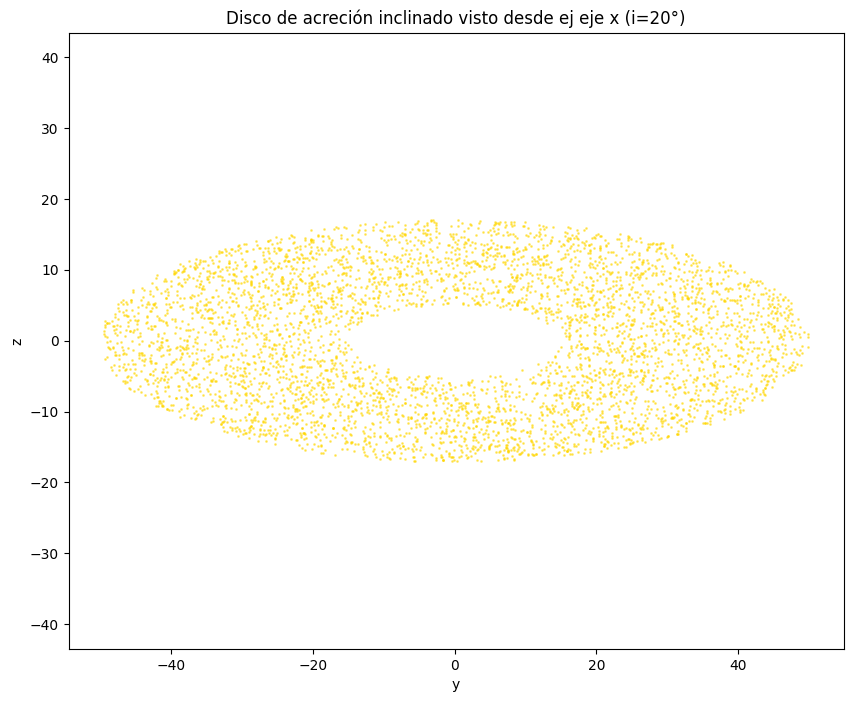

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_rot, z_rot, s=1, alpha=0.5, color='gold')
plt.xlabel('y')
plt.ylabel('z')
plt.title(f'Disco de acreción inclinado visto desde ej eje x (i={i}°)')
plt.axis('equal')
plt.show()

# **Parte 4**

## *Intersecciones rayo-disco en 3D y síntesis de la imagen*

Para rotar un rayo en el plano $xy$ a su orientación original, utilizamos una matriz de rotación alrededor del eje x:

$$
R_x(\theta) =
\begin{pmatrix}
1 & 0 & 0 \\
0 & \cos\theta & -\sin\theta \\
0 & \sin\theta & \cos\theta
\end{pmatrix}
$$

donde $θ$ es el ángulo de lanzamiento correspondiente

In [ ]:
def matriz_rotacion_x(theta):
  cos = np.cos(theta)
  sin = np.sin(theta)
  matriz = np.array([
      [1,     0,      0],
      [0,  cos, -sin],
      [0,  sin,  cos]
  ])
  return matriz

In [ ]:
from scipy.spatial.transform import Rotation as R

Posteriormente, se determinó si el conjunto de trayectorias (rayos proyectados) intersecta con el disco en el espacio tridimensional. La detección de intersección se determina mediante la distancia entre cada punto de una trayectoria rotada y los puntos que representan el disco.

Las trayectorias de rayos se consideran inicialmente en el plano bidimensional $(x, y)$, correspondiente al plano imagen del observador. Para evaluar su interacción con el disco tridimensional, estas trayectorias se extienden  al espacio tridimensional asumiendo una componente $z = 0$, es decir, cada punto de la trayectoria se representa como $\mathbf{p}_i = (x_i, y_i, 0)$. Luego, al igual que el disco, las trayectorias se rotan mediante la matriz $R_x(\theta)$, de modo que queden en el mismo sistema inclinado que el disco.


Para determinar si una trayectoria intersecta el disco, se analiza la proximidad entre cada punto $\mathbf{p}_i^{\text{rot}}$ de la trayectoria rotada y los puntos del disco rotado $\{ \mathbf{q}_j^{\text{rot}} \}$. El criterio se basa en la distancia euclidiana:

$$
d_{ij} = \| \mathbf{q}_j^{\text{rot}} - \mathbf{p}_i^{\text{rot}} \|
$$

de modo que que ocurre una intersección si existe algún índice $j$ tal que $d_{ij} < d_{ave}$.


In [ ]:
intersecciones = []

#Iteramos sobre cada trayectoria y su ángulo de rotación correspondiente
for i, trayectoria in enumerate(trayectorias):
  theta = theta0[i]
  R_x = matriz_rotacion_x(theta) #Matriz de rotación alrededor del eje X para inclinar el disco

  rayos_2d = trayectoria[:, [0,1]] #Extraemos solo las componentes x e y de la trayectoria 2D
  z = np.zeros_like(rayos_2d[:, 0])
  #Trayectoria en 3D agregando la componente z = 0
  rayos_3d = np.stack([rayos_2d[:, 0], rayos_2d[:, 1], z], axis=1)

  #Aplicamos la rotación a los rayos para simular la inclinación del disco
  rayos_rotados = rayos_3d @ R_x.T #Multiplicamos por la transpuesta para aplicar la rotación

  hit = -999 #Distancia radial respecto al agujero negro en la que ocurre la intersección

  #Verificamos si algún punto del rayo está lo suficientemente cerca del disco
  for p in rayos_rotados:
    dists = np.linalg.norm(puntos_rotados - p, axis=1)
    min_dist = np.min(dists) #Distancia mínima desde el punto actual del rayo al disco
    if min_dist < d_ave: #Verificamos si está dentro del umbral considerado como intersección
      hit = np.linalg.norm(p)
      break
  intersecciones.append(hit)

### Visualización de los rayos en el plano $yz$

Veamos entonces la distribución espacial de las trayectorias en el plano $yz$, incluyendo tanto los rayos que son absorbidos por el agujero negro o continúan sin desviación, como aquellos que interactúan con el disco de acreción.

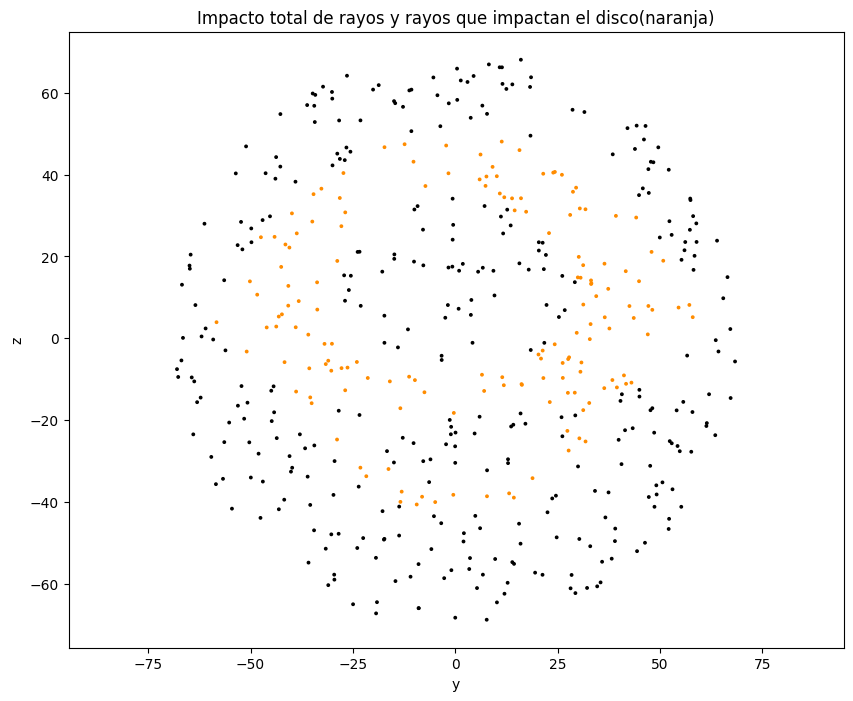

In [ ]:
impactos = np.array(intersecciones)
#Si el valor de impacto es negativo, es decir, el rayo fue absorbido por el agujero negro, se asigna el color negro.
#En caso contrario , si el rayo se interseca con el disco, se asigna el color naranja.
colores = np.where(impactos < 0, 'black', 'darkorange')

plt.figure(figsize=(10, 8))
plt.scatter(y0, -z0,s=3, color=colores)
plt.xlabel("y")
plt.ylabel("z")
plt.title("Impacto total de rayos y rayos que impactan el disco(naranja)")
plt.axis("equal")
plt.show()

Veamos ahora que sucede si aumentamos el número de rayos a $N=100000$

In [ ]:
Nn = 100000
Rn = 70

In [ ]:
rn0, thetan0, yn0, zn0 = generar_circulo(Nn, Rn) #Nuevas posiciones iniciales
trayectoriasn = integracion_rayo(x_start, rn0)

<ipython-input-8-1a8249dbd0e9>:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(flow_deriv, estado_inicial, tspan, args=(A,)) #Resolvemos las ecuaciones diferenciales
<ipython-input-8-1a8249dbd0e9>:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(flow_deriv, estado_inicial, tspan, args=(A,)) #Resolvemos las ecuaciones diferenciales
<ipython-input-8-1a8249dbd0e9>:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(flow_deriv, estado_inicial, tspan, args=(A,)) #Resolvemos las ecuaciones diferenciales
<ipython-input-8-1a8249dbd0e9>:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(flow_deriv, estado_

In [ ]:
interseccionesn = []

for i, trayectoria in enumerate(trayectoriasn):
  theta = thetan0[i]
  R_x = matriz_rotacion_x(theta)

  rayos_2d = trayectoria[:, [0,1]]
  z = np.zeros_like(rayos_2d[:, 0])
  rayos_3d = np.stack([rayos_2d[:, 0], rayos_2d[:, 1], z], axis=1)

  rayos_rotados = rayos_3d @ R_x.T

  hit = -999
  for p in rayos_rotados:
    dists = np.linalg.norm(puntos_rotados - p, axis=1)
    min_dist = np.min(dists)
    if min_dist < d_ave:
      hit = np.linalg.norm(p)
      break
  interseccionesn.append(hit)

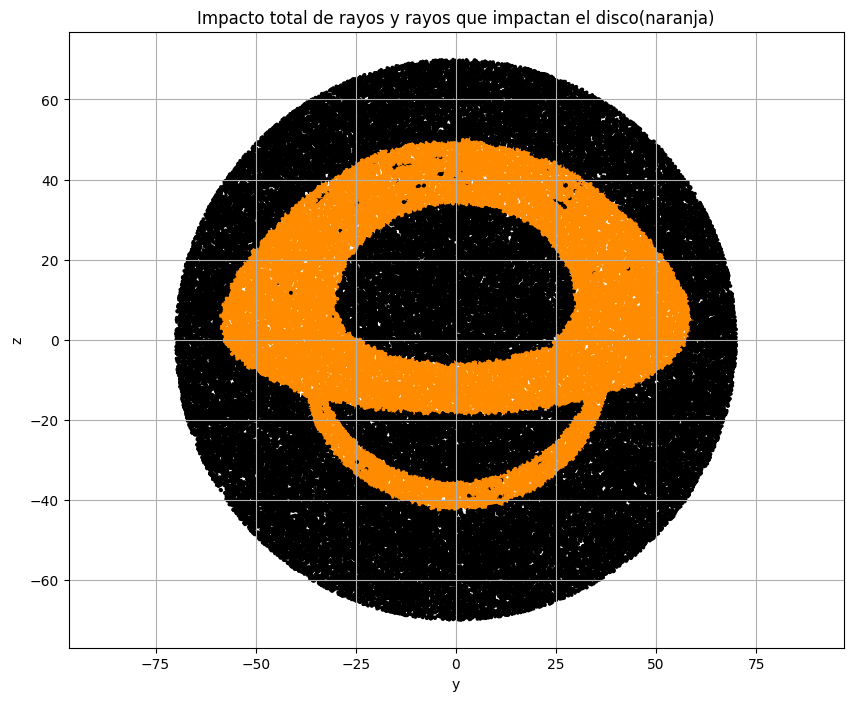

In [ ]:
impactosn = np.array(interseccionesn)
colores = np.where(impactosn < 0, 'black', 'darkorange')

plt.figure(figsize=(10, 8))
plt.scatter(yn0, -zn0,s=3, color=colores)
plt.xlabel("y")
plt.ylabel("z")
plt.title("Impacto total de rayos y rayos que impactan el disco(naranja)")
plt.axis("equal")
plt.grid(True)
plt.show()

### Visualización del agujero negro

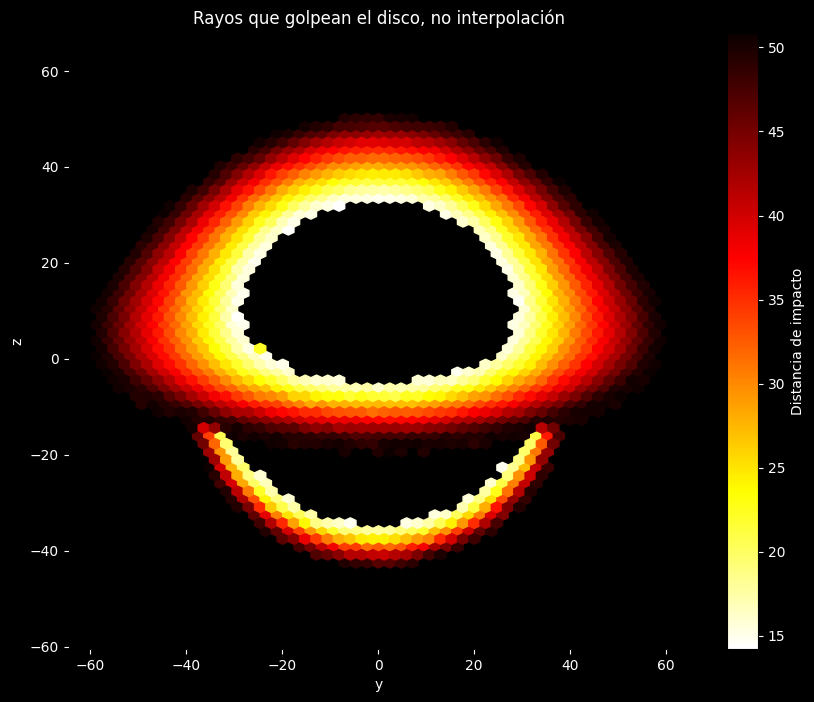

In [ ]:
# Filtramos solo impactos válidos
yn_hits = []
zn_hits = []
choquesn_hits = []

for i in range(len(interseccionesn)):
  if interseccionesn[i] != -999:
    yn_hits.append(yn0[i])
    zn_hits.append(-zn0[i])
    choquesn_hits.append(interseccionesn[i])

fig = plt.figure(figsize=(10,8), facecolor='black')
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')

hb = ax.hexbin(yn_hits, zn_hits, C=choquesn_hits, gridsize=50, cmap='hot_r', mincnt=0.0001)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Distancia de impacto', color='white')
cb.ax.yaxis.set_tick_params(color='white')
plt.setp(cb.ax.yaxis.get_ticklabels(), color='white')

ax.set_title("Rayos que golpean el disco, no interpolación", color='white')
ax.set_xlabel("y", color='white')
ax.set_ylabel("z", color='white')
ax.axis("equal")
ax.tick_params(colors='white')
plt.show()